In this file, I will repeat the random forest without service fee as a predictor. It will help to understand the effect of servie fee as a variable.

Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker

import seaborn as sns

import folium
from folium.plugins import HeatMap

In [2]:
#packages for regression

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

In [3]:
# defiitions for plot size and line thickness
def mm2inch(*tupl):
    inch = 25.4
    if isinstance(tupl[0], tuple):
        return tuple(i/inch for i in tupl[0])
    else:
        return tuple(i/inch for i in tupl)
def mm2point(mm):
    return mm/(25.4/72)
font = {'family' : 'Arial',
         'weight' : 'normal',
         'size'   : 15}
mpl.rc('font', **font)
mpl.rcParams['axes.linewidth'] = mm2point(0.4)
mpl.rcParams['ytick.major.width'] = mm2point(0.4)
mpl.rcParams['xtick.major.width'] = mm2point(0.4)

In [4]:
#setting the options to show all the columns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

Reading the airbnb csv file

In [5]:
df= pd.read_csv("Airbnb_Open_Data.csv")

C:\Users\Raisul\AppData\Local\Temp\ipykernel_12132\721149800.py:1: DtypeWarning: Columns (25) have mixed types. Specify dtype option on import or set low_memory=False.
  df= pd.read_csv("Airbnb_Open_Data.csv")


In [6]:
#Looking at the first 5 rows of the dataset
df.head()

,id,NAME,host id,host_identity_verified,host name,neighbourhood group,neighbourhood,lat,long,country,country code,instant_bookable,cancellation_policy,room type,Construction year,price,service fee,minimum nights,number of reviews,last review,reviews per month,review rate number,calculated host listings count,availability 365,house_rules,license
0,1001254,Clean & quiet apt home by the park,80014485718,unconfirmed,Madaline,Brooklyn,Kensington,40.64749,-73.97237,United States,US,False,strict,Private room,2020.0,$966,$193,10.0,9.0,10/19/2021,0.21,4.0,6.0,286.0,Clean up and treat the home the way you'd like...,NaN
1,1002102,Skylit Midtown Castle,52335172823,verified,Jenna,Manhattan,Midtown,40.75362,-73.98377,United States,US,False,moderate,Entire home/apt,2007.0,$142,$28,30.0,45.0,5/21/2022,0.38,4.0,2.0,228.0,Pet friendly but please confirm with me if the...,NaN
2,1002403,THE VILLAGE OF HARLEM....NEW YORK !,78829239556,NaN,Elise,Manhattan,Harlem,40.80902,-73.94190,United States,US,True,flexible,Private room,2005.0,$620,$124,3.0,0.0,NaN,NaN,5.0,1.0,352.0,"I encourage you to use my kitchen, cooking and...",NaN
3,1002755,NaN,85098326012,unconfirmed,Garry,Brooklyn,Clinton Hill,40.68514,-73.95976,United States,US,True,moderate,Entire home/apt,2005.0,$368,$74,30.0,270.0,7/5/2019,4.64,4.0,1.0,322.0,NaN,NaN
4,1003689,Entire Apt: Spacious Studio/Loft by central park,92037596077,verified,Lyndon,Manhattan,East Harlem,40.79851,-73.94399,United States,US,False,moderate,Entire home/apt,2009.0,$204,$41,10.0,9.0,11/19/2018,0.10,3.0,1.0,289.0,"Please no smoking in the house, porch or on th...",NaN


In [7]:
#Looking at the lenth and columns of the dataset
print("Lenth of the dataset:",len(df))
print("Column names:",df.columns)

Lenth of the dataset: 102599
Column names: Index(['id', 'NAME', 'host id', 'host_identity_verified', 'host name',
       'neighbourhood group', 'neighbourhood', 'lat', 'long', 'country',
       'country code', 'instant_bookable', 'cancellation_policy', 'room type',
       'Construction year', 'price', 'service fee', 'minimum nights',
       'number of reviews', 'last review', 'reviews per month',
       'review rate number', 'calculated host listings count',
       'availability 365', 'house_rules', 'license'],
      dtype='object')


Random Forest

My objective is to predict the price by using other values. So, price is the response, while other variables are predictors.

In [8]:
#Keeping only the files relevant for the regression
df1= df[['id',
       'neighbourhood group', 
       #'neighbourhood', 
       'lat', 'long', 
       #'country',
       #'country code', 
       'instant_bookable', 'cancellation_policy', 'room type',
       'Construction year', 'price', 
       #'service fee', 
       'minimum nights',
       'number of reviews', 
       
       'review rate number', 'calculated host listings count',
       'availability 365']]

In [9]:
#Looking at the first few rows
df1.head()

,id,neighbourhood group,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,minimum nights,number of reviews,review rate number,calculated host listings count,availability 365
0,1001254,Brooklyn,40.64749,-73.97237,False,strict,Private room,2020.0,$966,10.0,9.0,4.0,6.0,286.0
1,1002102,Manhattan,40.75362,-73.98377,False,moderate,Entire home/apt,2007.0,$142,30.0,45.0,4.0,2.0,228.0
2,1002403,Manhattan,40.80902,-73.94190,True,flexible,Private room,2005.0,$620,3.0,0.0,5.0,1.0,352.0
3,1002755,Brooklyn,40.68514,-73.95976,True,moderate,Entire home/apt,2005.0,$368,30.0,270.0,4.0,1.0,322.0
4,1003689,Manhattan,40.79851,-73.94399,False,moderate,Entire home/apt,2009.0,$204,10.0,9.0,3.0,1.0,289.0


In [10]:
#Looking at the number of rows and columns
df1.shape

(102599, 14)

In [11]:
#Now looking at the data types of the columns
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   neighbourhood group             102570 non-null  object 
 2   lat                             102591 non-null  float64
 3   long                            102591 non-null  float64
 4   instant_bookable                102494 non-null  object 
 5   cancellation_policy             102523 non-null  object 
 6   room type                       102599 non-null  object 
 7   Construction year               102385 non-null  float64
 8   price                           102352 non-null  object 
 9   minimum nights                  102190 non-null  float64
 10  number of reviews               102416 non-null  float64
 11  review rate number              102273 non-null  float64
 12  calculated host 

Here we see the price and service fee columns are object type, whcih should be as interger or float. So, converting these 2 columns into float.


In [12]:
df1["price"]= df1["price"].str[1:].str.replace(",", "").astype(float) # deleting the $ sign and converting to float datatype
#df1["service fee"]= df1["service fee"].str[1:].str.replace(",", "").astype(float)

C:\Users\Raisul\AppData\Local\Temp\ipykernel_12132\2327620404.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["price"]= df1["price"].str[1:].str.replace(",", "").astype(float) # deleting the $ sign and converting to float datatype


Now it should be checked if the columns are converted into float.

In [13]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102599 entries, 0 to 102598
Data columns (total 14 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   id                              102599 non-null  int64  
 1   neighbourhood group             102570 non-null  object 
 2   lat                             102591 non-null  float64
 3   long                            102591 non-null  float64
 4   instant_bookable                102494 non-null  object 
 5   cancellation_policy             102523 non-null  object 
 6   room type                       102599 non-null  object 
 7   Construction year               102385 non-null  float64
 8   price                           102352 non-null  float64
 9   minimum nights                  102190 non-null  float64
 10  number of reviews               102416 non-null  float64
 11  review rate number              102273 non-null  float64
 12  calculated host 

In [14]:
#Now check the unique values of the neighbourhood group column.
print("Unique values are:", df1["neighbourhood group"].unique())
#Also, counting the numbers of these unique values
print("Counts of these unique values of",df1["neighbourhood group"].value_counts())

Unique values are: ['Brooklyn' 'Manhattan' 'brookln' 'manhatan' 'Queens' nan 'Staten Island'
 'Bronx']
Counts of these unique values of neighbourhood group
Manhattan        43792
Brooklyn         41842
Queens           13267
Bronx             2712
Staten Island      955
brookln              1
manhatan             1
Name: count, dtype: int64


It seems the last two unique values of neighbourhood (group brookln and manhatan) are just type error. It could be updated as the original name (Brooklyn, Manhattan). 

In [15]:
df1.loc[df1["neighbourhood group"] == "brookln", "neighbourhood group"] = "Brooklyn"
df1.loc[df1["neighbourhood group"] == "manhatan", "neighbourhood group"] = "Manhattan"

In [16]:
#Now check if everythig is ok
print("Unique values are:", df1["neighbourhood group"].unique())
print("Counts of these unique values of",df1["neighbourhood group"].value_counts())

Unique values are: ['Brooklyn' 'Manhattan' 'Queens' nan 'Staten Island' 'Bronx']
Counts of these unique values of neighbourhood group
Manhattan        43793
Brooklyn         41843
Queens           13267
Bronx             2712
Staten Island      955
Name: count, dtype: int64


Now creating a dictionary of coordinates of the centers of these five major administrative divisions

In [17]:
nyc_boroughs_coordinates = {
    'Manhattan': {'latitude': 40.7831, 'longitude': -73.9712},
    'Brooklyn': {'latitude': 40.6782, 'longitude': -73.9442},
    'Queens': {'latitude': 40.7282, 'longitude': -73.7949},
    'Bronx': {'latitude': 40.8448, 'longitude': -73.8648},
    'Staten Island': {'latitude': 40.5795, 'longitude': -74.1502}
}

In [18]:
#converting this dictionary into dataframe
nyc_coordinates= pd.DataFrame.from_dict(nyc_boroughs_coordinates
                                      ,orient="index"
                                      ).reset_index()

nyc_coordinates

,index,latitude,longitude
0,Manhattan,40.7831,-73.9712
1,Brooklyn,40.6782,-73.9442
2,Queens,40.7282,-73.7949
3,Bronx,40.8448,-73.8648
4,Staten Island,40.5795,-74.1502


In [19]:
#now renaming the name of the columns of nyc_coordinates
nyc_coordinates.columns= ["neighbourhood group", "neighbour_lat", "neighbour_lon"]
nyc_coordinates

,neighbourhood group,neighbour_lat,neighbour_lon
0,Manhattan,40.7831,-73.9712
1,Brooklyn,40.6782,-73.9442
2,Queens,40.7282,-73.7949
3,Bronx,40.8448,-73.8648
4,Staten Island,40.5795,-74.1502


Merge nyc_coordinates with df1 based on neighbourhood group

In [20]:
df_merge= df1.merge(nyc_coordinates, on="neighbourhood group", how="inner")
df_merge.head()

,id,neighbourhood group,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,minimum nights,number of reviews,review rate number,calculated host listings count,availability 365,neighbour_lat,neighbour_lon
0,1001254,Brooklyn,40.64749,-73.97237,False,strict,Private room,2020.0,966.0,10.0,9.0,4.0,6.0,286.0,40.6782,-73.9442
1,1002755,Brooklyn,40.68514,-73.95976,True,moderate,Entire home/apt,2005.0,368.0,30.0,270.0,4.0,1.0,322.0,40.6782,-73.9442
2,1004650,Brooklyn,40.68688,-73.95596,False,moderate,Private room,2015.0,71.0,45.0,49.0,5.0,1.0,224.0,40.6782,-73.9442
3,1005202,Brooklyn,40.68688,-73.95596,False,moderate,Private room,2009.0,1060.0,45.0,49.0,5.0,1.0,219.0,40.6782,-73.9442
4,1008516,Brooklyn,40.66829,-73.98779,True,moderate,Private room,2010.0,580.0,4.0,167.0,4.0,3.0,47.0,40.6782,-73.9442


In [21]:
#checking the shape of the df_merge
df_merge.shape

(102570, 16)

My target is to get the distance between the location of each property and the center of it's neighbourhood group. 

Write a function to get the distance between the property location and it's neighbourhood

In [22]:
def haversine(lat1, lon1, lat2, lon2):
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    
    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371000  # Radius of Earth in meters
    return c * r

def calculate_distances(df_merge):
    # Apply the Haversine function to each row in the DataFrame
    df_merge['distance(m)'] = df_merge.apply(lambda row: haversine(row['lat'], row['long'], row['neighbour_lat'], row['neighbour_lon']), axis=1)
    return df_merge

In [23]:
#Run the function to calculate distances
df_distance= calculate_distances(df_merge)

In [24]:
df_distance.head()

,id,neighbourhood group,lat,long,instant_bookable,cancellation_policy,room type,Construction year,price,minimum nights,number of reviews,review rate number,calculated host listings count,availability 365,neighbour_lat,neighbour_lon,distance(m)
0,1001254,Brooklyn,40.64749,-73.97237,False,strict,Private room,2020.0,966.0,10.0,9.0,4.0,6.0,286.0,40.6782,-73.9442,4160.115741
1,1002755,Brooklyn,40.68514,-73.95976,True,moderate,Entire home/apt,2005.0,368.0,30.0,270.0,4.0,1.0,322.0,40.6782,-73.9442,1522.190119
2,1004650,Brooklyn,40.68688,-73.95596,False,moderate,Private room,2015.0,71.0,45.0,49.0,5.0,1.0,224.0,40.6782,-73.9442,1383.798669
3,1005202,Brooklyn,40.68688,-73.95596,False,moderate,Private room,2009.0,1060.0,45.0,49.0,5.0,1.0,219.0,40.6782,-73.9442,1383.798669
4,1008516,Brooklyn,40.66829,-73.98779,True,moderate,Private room,2010.0,580.0,4.0,167.0,4.0,3.0,47.0,40.6782,-73.9442,3837.746772


In [25]:
#Looking at the columns
df_distance.columns

Index(['id', 'neighbourhood group', 'lat', 'long', 'instant_bookable',
       'cancellation_policy', 'room type', 'Construction year', 'price',
       'minimum nights', 'number of reviews', 'review rate number',
       'calculated host listings count', 'availability 365', 'neighbour_lat',
       'neighbour_lon', 'distance(m)'],
      dtype='object')

In [26]:
#Keeping only the columns useful for the regression
df2= df_distance[['neighbourhood group', 'instant_bookable',
       'cancellation_policy', 'room type', 'Construction year', 'price',
       #'service fee', 
       'minimum nights', 'number of reviews',
       'review rate number', 'calculated host listings count',
       'availability 365', 'distance(m)']]

In [27]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102570 entries, 0 to 102569
Data columns (total 12 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   neighbourhood group             102570 non-null  object 
 1   instant_bookable                102466 non-null  object 
 2   cancellation_policy             102495 non-null  object 
 3   room type                       102570 non-null  object 
 4   Construction year               102361 non-null  float64
 5   price                           102324 non-null  float64
 6   minimum nights                  102162 non-null  float64
 7   number of reviews               102387 non-null  float64
 8   review rate number              102246 non-null  float64
 9   calculated host listings count  102251 non-null  float64
 10  availability 365                102133 non-null  float64
 11  distance(m)                     102562 non-null  float64
dtypes: float64(8), o

In [28]:
#transform categorical values into boolean (one hot encoding)

df_encoded = pd.get_dummies(df2, columns=['room type'], drop_first=True)
df_encoded = pd.get_dummies(df_encoded, columns=['neighbourhood group'], drop_first=False)
df_encoded = pd.get_dummies(df_encoded, columns=['cancellation_policy'], drop_first=False)
df_encoded = pd.get_dummies(df_encoded, columns=['instant_bookable'], drop_first=True)

In [29]:
df_encoded.head()

,Construction year,price,minimum nights,number of reviews,review rate number,calculated host listings count,availability 365,distance(m),room type_Hotel room,room type_Private room,room type_Shared room,neighbourhood group_Bronx,neighbourhood group_Brooklyn,neighbourhood group_Manhattan,neighbourhood group_Queens,neighbourhood group_Staten Island,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,instant_bookable_True
0,2020.0,966.0,10.0,9.0,4.0,6.0,286.0,4160.115741,False,True,False,False,True,False,False,False,False,False,True,False
1,2005.0,368.0,30.0,270.0,4.0,1.0,322.0,1522.190119,False,False,False,False,True,False,False,False,False,True,False,True
2,2015.0,71.0,45.0,49.0,5.0,1.0,224.0,1383.798669,False,True,False,False,True,False,False,False,False,True,False,False
3,2009.0,1060.0,45.0,49.0,5.0,1.0,219.0,1383.798669,False,True,False,False,True,False,False,False,False,True,False,False
4,2010.0,580.0,4.0,167.0,4.0,3.0,47.0,3837.746772,False,True,False,False,True,False,False,False,False,True,False,True


In [30]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102570 entries, 0 to 102569
Data columns (total 20 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Construction year                  102361 non-null  float64
 1   price                              102324 non-null  float64
 2   minimum nights                     102162 non-null  float64
 3   number of reviews                  102387 non-null  float64
 4   review rate number                 102246 non-null  float64
 5   calculated host listings count     102251 non-null  float64
 6   availability 365                   102133 non-null  float64
 7   distance(m)                        102562 non-null  float64
 8   room type_Hotel room               102570 non-null  bool   
 9   room type_Private room             102570 non-null  bool   
 10  room type_Shared room              102570 non-null  bool   
 11  neighbourhood group_Bronx          1025

In [31]:
#Converting boolean into integer

bool_cols = df_encoded.select_dtypes(include='bool').columns
df_encoded[bool_cols] = df_encoded[bool_cols].astype(int)

In [32]:
df_encoded.head(n=5)

,Construction year,price,minimum nights,number of reviews,review rate number,calculated host listings count,availability 365,distance(m),room type_Hotel room,room type_Private room,room type_Shared room,neighbourhood group_Bronx,neighbourhood group_Brooklyn,neighbourhood group_Manhattan,neighbourhood group_Queens,neighbourhood group_Staten Island,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,instant_bookable_True
0,2020.0,966.0,10.0,9.0,4.0,6.0,286.0,4160.115741,0,1,0,0,1,0,0,0,0,0,1,0
1,2005.0,368.0,30.0,270.0,4.0,1.0,322.0,1522.190119,0,0,0,0,1,0,0,0,0,1,0,1
2,2015.0,71.0,45.0,49.0,5.0,1.0,224.0,1383.798669,0,1,0,0,1,0,0,0,0,1,0,0
3,2009.0,1060.0,45.0,49.0,5.0,1.0,219.0,1383.798669,0,1,0,0,1,0,0,0,0,1,0,0
4,2010.0,580.0,4.0,167.0,4.0,3.0,47.0,3837.746772,0,1,0,0,1,0,0,0,0,1,0,1


In [33]:
df_encoded.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102570 entries, 0 to 102569
Data columns (total 20 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Construction year                  102361 non-null  float64
 1   price                              102324 non-null  float64
 2   minimum nights                     102162 non-null  float64
 3   number of reviews                  102387 non-null  float64
 4   review rate number                 102246 non-null  float64
 5   calculated host listings count     102251 non-null  float64
 6   availability 365                   102133 non-null  float64
 7   distance(m)                        102562 non-null  float64
 8   room type_Hotel room               102570 non-null  int32  
 9   room type_Private room             102570 non-null  int32  
 10  room type_Shared room              102570 non-null  int32  
 11  neighbourhood group_Bronx          1025

In [34]:
#drop the na values
df_reg= df_encoded.dropna()

In [35]:
len(df_reg)

100647

In [36]:
X = df_reg.drop('price', axis=1)
y = df_reg["price"]

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit the linear regression model
model = RandomForestRegressor(random_state=42)
model.fit(X_train, y_train)

# Make predictions and evaluate the model
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R² value: {r2}')


# Print the feature importances
feature_importances = pd.DataFrame(model.feature_importances_, X.columns, columns=['Importance'])
print("\nFeature importances from the Random Forest model:")
print(feature_importances.sort_values(by="Importance", ascending=False))

Mean Squared Error: 76714.9827508757
R² value: 0.29886452798830965

Feature importances from the Random Forest model:
                                   Importance
distance(m)                          0.263409
availability 365                     0.158274
number of reviews                    0.143557
Construction year                    0.117131
minimum nights                       0.075848
review rate number                   0.063116
calculated host listings count       0.053195
room type_Private room               0.022491
instant_bookable_True                0.018229
cancellation_policy_moderate         0.013523
cancellation_policy_flexible         0.013450
neighbourhood group_Manhattan        0.013226
cancellation_policy_strict           0.013168
neighbourhood group_Brooklyn         0.012719
neighbourhood group_Queens           0.007779
neighbourhood group_Bronx            0.004533
room type_Shared room                0.004099
neighbourhood group_Staten Island    0.002002
room typ

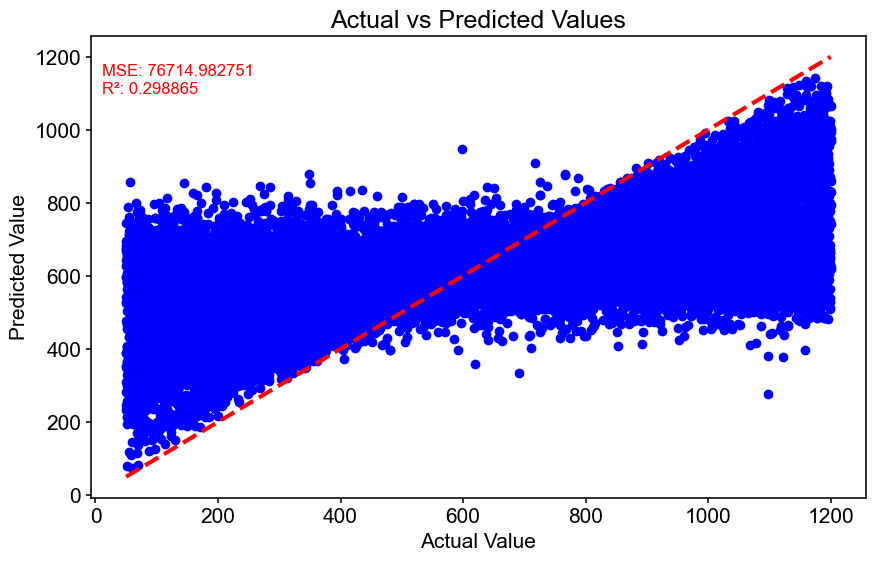

In [37]:
# Plot y_predicted vs y_test
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, color='blue')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', linewidth=3)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('Actual vs Predicted Values')
plt.text(10, 1100, f'MSE: 76714.982751\nR²: 0.298865', fontsize=12, color='red')
#plt.savefig("E:/ReDi_School/Data_Analytics/Project/Figure/10_ActualVsPredicted_rf_exServicefee")
plt.show()

Now plot bar diagram for the important features

In [38]:
#First, sort the importance score in the descending order
feature_importance_sort= feature_importances.sort_values(by= "Importance", ascending=False)

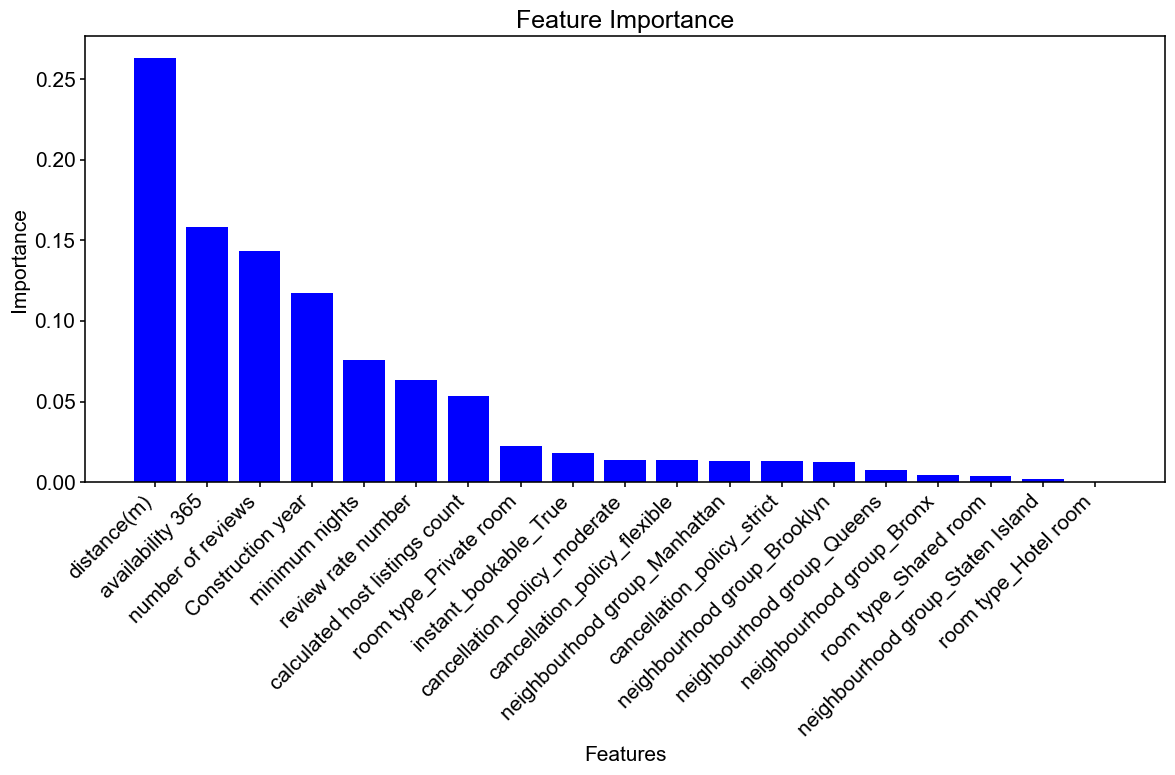

In [40]:
plt.figure(figsize=(12, 8))

# Plot positive coefficients
plt.bar(feature_importance_sort.index, feature_importance_sort["Importance"], color='blue')

plt.axhline(0, color='black', linewidth=0.5)  # Add horizontal line at y=0 for clarity
plt.xlabel('Features')
plt.ylabel('Importance')
plt.title('Feature Importance')
plt.xticks(rotation=45, ha='right')
#plt.legend(fontsize=10) # Display legend

# Set y-axis to logarithmic scale
#plt.yscale('log')

plt.tight_layout()
#plt.savefig("E:/ReDi_School/Data_Analytics/Project/Figure/11_FeatureImportance_rf_exServicefee")
plt.show()

According to the analysis, it seems it is not possible to get a better prediction of price without serive fee by using random forest.